In [1]:
path = '/Users/jaeyeobjeong/Desktop/포트폴리오/프로젝트/소비예측_경진대회/data'

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
train = pd.read_csv(f'{path}/train_0504.csv')
test = pd.read_csv(f'{path}/test_0504.csv')

In [4]:
# 범주형 변수 중 여러 class를 가지고 있는 변수에 대해 one-hot encoding 실시
ohe_features = ['Education', 'Marital_Status']

train_ohe, test_ohe = pd.DataFrame(), pd.DataFrame()
for feat in ohe_features:
    # 라벨 인코더 생성
    encoder = OneHotEncoder()

    # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
    train_oh_encoded = encoder.fit_transform(train[feat].values.reshape(-1,1)).toarray()
    test_oh_encoded = encoder.transform(test[feat].values.reshape(-1,1)).toarray()

    train_oh = pd.DataFrame(train_oh_encoded, 
                 columns = [feat + '_' + value for value in train[feat].unique()])
    test_oh = pd.DataFrame(test_oh_encoded, 
                 columns = [feat + '_' + value for value in train[feat].unique()])
    
    train_ohe = pd.concat([train_ohe, train_oh], axis = 1)
    test_ohe = pd.concat([test_ohe, test_oh], axis = 1)

In [5]:
train = pd.concat([train, train_ohe], axis = 1)
test = pd.concat([test, test_ohe], axis = 1)

In [6]:
# one-hot encoding이 적용된 것을 확인
train_ohe.columns

Index(['Education_Master', 'Education_Graduation', 'Education_Basic',
       'Education_PhD', 'Education_2n Cycle', 'Marital_Status_Together',
       'Marital_Status_Single', 'Marital_Status_Married',
       'Marital_Status_Widow', 'Marital_Status_Divorced',
       'Marital_Status_Alone', 'Marital_Status_YOLO', 'Marital_Status_Absurd'],
      dtype='object')

## Validation

### Set X, y

In [7]:
in_cat_features = ['Income', 'NumWebVisitsMonth', 'NumPurchases', 
                     'customer_terms', 'register_age', 
                     'Kidhome', 'Teenhome',
                     'Sum_AcceptedCmp', 'Complain',
                     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                     'Education_Master', 'Education_Graduation', 'Education_Basic',
                     'Education_PhD', 'Education_2n Cycle', 'Marital_Status_Together',
                     'Marital_Status_Single', 'Marital_Status_Married',
                     'Marital_Status_Widow', 'Marital_Status_Divorced',
                     'Marital_Status_Alone', 'Marital_Status_YOLO', 'Marital_Status_Absurd']

In [8]:
X = train[in_cat_features]
y = np.sqrt(train['target']) # Target의 분포를 고려한 변수 처리

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Cross Validation

In [14]:
val_xgb = XGBRegressor(random_state = 0)
val_rf = RandomForestRegressor(random_state = 0)
val_cat = CatBoostRegressor(random_state = 0, verbose = 1000)

In [16]:
scores_xgb = cross_val_score(val_xgb, X_train, y_train, cv = 5)
scores_rf = cross_val_score(val_rf, X_train, y_train, cv = 5)
scores_cat = cross_val_score(val_cat, X_train, y_train, cv = 5)

print()
print('Non Sampling XGB model :', scores_xgb)
print('Non Sampling RF model :', scores_rf)
print('Non Sampling CAT model :', scores_cat)

Learning rate set to 0.038378
0:	learn: 12.3589542	total: 571us	remaining: 571ms
999:	learn: 0.6286453	total: 542ms	remaining: 0us
Learning rate set to 0.038387
0:	learn: 12.3115512	total: 539us	remaining: 539ms
999:	learn: 0.6423695	total: 562ms	remaining: 0us
Learning rate set to 0.038387
0:	learn: 12.3053402	total: 447us	remaining: 447ms
999:	learn: 0.6519497	total: 549ms	remaining: 0us
Learning rate set to 0.038387
0:	learn: 12.4974882	total: 671us	remaining: 671ms
999:	learn: 0.5983661	total: 552ms	remaining: 0us
Learning rate set to 0.038387
0:	learn: 12.3100398	total: 479us	remaining: 479ms
999:	learn: 0.6405852	total: 559ms	remaining: 0us

Non Sampling XGB model : [0.91057876 0.9090089  0.91594403 0.92745861 0.93895713]
Non Sampling RF model : [0.91332696 0.91926901 0.91848105 0.92854868 0.94214018]
Non Sampling CAT model : [0.92024365 0.93797858 0.93352201 0.94016911 0.94541048]


- CatBoost의 성능이 CV에서 전체적으로 가장 높은 정확도(Accuracy)를 보임

### Scoring by NMAE

In [19]:
# 대회 평가지표
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

In [20]:
val_cat = CatBoostRegressor(random_state = 0, verbose = 500)
val_cat.fit(X_train, y_train)
y_pred = val_cat.predict(X_test) # y예측

print(f'모델 NMAE: {nmae(y_test**2,y_pred**2)}')

Learning rate set to 0.039763
0:	learn: 12.3323902	total: 1.18ms	remaining: 1.18s
500:	learn: 1.2882153	total: 291ms	remaining: 290ms
999:	learn: 0.7010502	total: 578ms	remaining: 0us
모델 NMAE: 0.15961383631608758


In [21]:
val_rf = RandomForestRegressor(random_state = 0)
val_rf.fit(X_train, y_train)
y_pred = val_rf.predict(X_test) # y예측

print(f'모델 NMAE: {nmae(y_test**2,y_pred**2)}')

모델 NMAE: 0.17695867412602348


In [22]:
val_xgb = XGBRegressor(random_state = 0)
val_xgb.fit(X_train, y_train)
y_pred = val_xgb.predict(X_test) # y예측

print(f'모델 NMAE: {nmae(y_test**2,y_pred**2)}')

모델 NMAE: 0.16772335459029825


- CatBoost의 성능이 대회 평가지표인 NMAE에서도 가장 좋은 성능

## Submission Modeling

In [28]:
X_train = train[in_cat_features]
y_train = np.sqrt(train['target'])

X_test = test[in_cat_features]

In [29]:
print(X_train.shape, y_train.shape, X_test.shape)

(1108, 26) (1108,) (1108, 26)


In [30]:
cat = CatBoostRegressor(random_state = 0, verbose = 500)
cat.fit(X_train, y_train)

pred = cat.predict(X_test)

Learning rate set to 0.041612
0:	learn: 12.3997651	total: 1.49ms	remaining: 1.49s
500:	learn: 1.4351931	total: 321ms	remaining: 320ms
999:	learn: 0.8761771	total: 638ms	remaining: 0us


In [31]:
submission = pd.read_csv(f'{path}/sample_submission.csv')

In [32]:
submission['target'] = [0 if p < 0 else p**2 for p in pred]

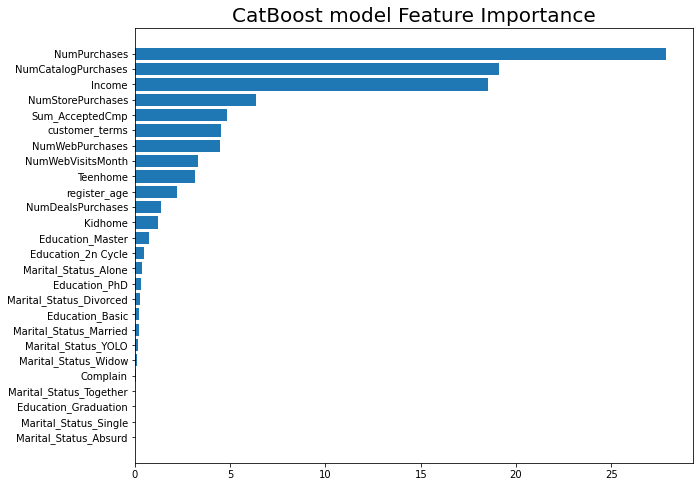

In [41]:
# catboost feature importance
feature_imp = pd.DataFrame(
{
    'feature_name' : in_cat_features,
    'feat_imp' : cat.feature_importances_
})
feature_imp.sort_values(by = 'feat_imp', ascending=True, inplace=True)

plt.figure(figsize = (10, 8))
plt.title('CatBoost model Feature Importance', fontsize = 20)
plt.barh('feature_name', 'feat_imp', data = feature_imp)
plt.show()

## Model Ensemble

### IDEA

- 다중 공선성이 높은 feature들을 다른 모델에 넣고 앙상블 시도

In [22]:
cat_features = []
xgb_features = []

## Submit Prediction

In [23]:
len(in_model_features)

26

In [24]:
submission.to_csv(f"{path}/Submissions/cat_0513_{len(in_model_features)}_sqrt.csv", index=False)

## Submission Analysis

In [142]:
print(train.Income.mean(), train.NumPurchases.mean())
print(test.Income.mean(), test.NumPurchases.mean())

52075.809566787 12.779783393501805
52418.693140794225 12.334837545126353


In [145]:
print(train.target.mean(), np.median(train.target))
print(pred.mean(), np.median(pred))

617.1218411552346 412.0
593.915173530633 382.0635517223699


In [107]:
print(train.target.mean(), np.median(train.target))
print(submission.target.mean(), np.median(submission.target))

617.1218411552346 412.0
589.793491366255 367.0823346996349


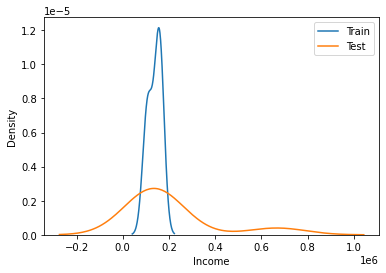

In [133]:
sns.kdeplot(train.query('Income > 100000')['Income'], label = 'Train')
sns.kdeplot(test.query('Income > 100000')['Income'], label = 'Test')
plt.legend()

<AxesSubplot:xlabel='target', ylabel='Density'>

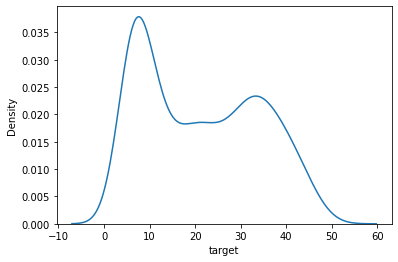

In [151]:
#sns.kdeplot(y_train)
sns.kdeplot(np.sqrt(y_train))

<AxesSubplot:xlabel='target', ylabel='Density'>

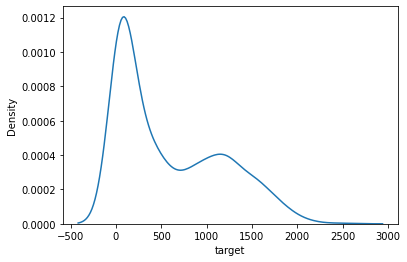

In [108]:
sns.kdeplot(submission['target'])